# VAE Training on COIL-100 (Google Colab)

This notebook trains the VAE model on **COIL-100 dataset** using Google Colab's free GPU.

## Dataset Info:
- **COIL-100**: 100 objects × 18 views (every 20°: 0°, 20°, ..., 340°)
- **Image size**: 128×128×3 RGB
- **Format**: Already in PyTorch format (N, C, H, W)

## Setup Instructions for VS Code + Colab:

1. **Open this notebook in VS Code**
2. **Connect to Colab**: Click kernel picker (top-right) → "Connect to Colab" → Choose GPU runtime (T4)
3. **Important**: When prompted with "Alias your server", just press Enter to confirm
4. **Run cell 2 below** - it will automatically detect your project location
5. **Note**: Your files are synced to the Colab runtime, but in a different path than your local Mac

## Expected Performance:
- **100 epochs**: ~5-10 minutes on GPU
- **500 epochs**: ~30-60 minutes

## 1. Check GPU Availability

In [11]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: GPU not detected! Go to Runtime → Change runtime type → GPU")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB


## 2. Auto-Detect Project Path

This cell automatically finds your project files wherever they are on the Colab runtime.
VS Code syncs your workspace, but the path on Colab is different from your local Mac path.

In [ ]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
print(f"📍 Current directory: {current_dir}")

DATA_TASK = "task2_interpolation"

# Check if we're in /content (Colab) and need to upload files
if current_dir == '/content':
    print("\n🔄 You're on Colab but files aren't synced yet.")
    print("\nOption 1: Upload via Google Drive (Recommended)")
    print("=" * 60)

    # Try to mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')

        # Check if project exists in Drive
        drive_path = '/content/drive/MyDrive/gppvae'
        if os.path.exists(drive_path):
            PROJECT_PATH = drive_path
            print(f"✅ Found project in Google Drive: {PROJECT_PATH}")
        else:
            print(f"\n⚠️  Project not found at: {drive_path}")
            print("\nTo upload your project to Google Drive:")
            print("1. Go to https://drive.google.com")
            print("2. Create a folder called 'gppvae' in My Drive")
            print("3. Upload these folders into it:")
            print("   - GPPVAE/ (code)")
            print("   - data/ (your data files)")
            print("   - notebooks/ (this notebook)")
            PROJECT_PATH = '/content'
    except Exception as e:
        print(f"Could not mount Drive: {e}")
        PROJECT_PATH = '/content'

    print(f"\n📂 Using project path: {PROJECT_PATH}")
else:
    # Running locally or files are synced
    if 'notebooks' in current_dir:
        PROJECT_PATH = os.path.dirname(current_dir)
    else:
        PROJECT_PATH = current_dir
    print(f"💻 Using project path: {PROJECT_PATH}")

# Verify what we have
print(f"\n📁 Contents of {PROJECT_PATH}:")
if os.path.exists(PROJECT_PATH):
    items = os.listdir(PROJECT_PATH)
    for item in sorted(items)[:15]:
        item_path = os.path.join(PROJECT_PATH, item)
        if os.path.isdir(item_path):
            print(f"   📂 {item}/")
        else:
            print(f"   📄 {item}")

    # Check for required folders (note: folder is coil-100 with hyphen)
    print(f"\n🔍 Checking required files:")
    required = {
        'GPPVAE': os.path.exists(os.path.join(PROJECT_PATH, 'GPPVAE')),
        'data': os.path.exists(os.path.join(PROJECT_PATH, 'data')),
        'data_coil.h5': os.path.exists(os.path.join(PROJECT_PATH, f'data/coil100/coil100_{DATA_TASK}.h5')),
    }

    for name, exists in required.items():
        status = "✅" if exists else "❌"
        print(f"   {status} {name}")

    if not all(required.values()):
        print(f"\n⚠️  Missing files! Please upload your gppvae folder to Google Drive")
else:
    print(f"❌ Path doesn't exist: {PROJECT_PATH}")

📍 Current directory: /content/drive/MyDrive/gppvae
💻 Using project path: /content/drive/MyDrive/gppvae

📁 Contents of /content/drive/MyDrive/gppvae:
   📂 GPPVAE/
   📂 data/
   📄 environment.yml
   📂 notebooks/
   📂 out/

🔍 Checking required files:
   ✅ GPPVAE
   ✅ data
   ✅ data_coil.h5


## 3. Install Dependencies

In [13]:
# Install required packages
!pip install -q wandb==0.12.21 imageio==2.15.0 pyyaml

# Check installations
import wandb
import imageio
import yaml
print("✅ All dependencies installed successfully!")

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
✅ All dependencies installed successfully!


## 4. Login to Weights & Biases (Optional)

If you want to track your experiments, login to W&B. Otherwise, skip this cell.

In [14]:
import wandb
wandb.login()

# Or set to offline mode if you don't want to use W&B
# os.environ['WANDB_MODE'] = 'offline'

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


False

## 5. Navigate to Project Directory

In [15]:
import os
os.chdir(PROJECT_PATH)
print(f"Current directory: {os.getcwd()}")

# Add project to Python path
import sys
sys.path.insert(0, os.path.join(PROJECT_PATH, 'GPPVAE/pysrc/faceplace'))

# List files to verify
print("\nProject structure:")
!ls -la

Current directory: /content/drive/MyDrive/gppvae

Project structure:
total 17
drwx------ 4 root root 4096 Dec 23 14:09 data
-rw------- 1 root root  258 Dec 23 11:40 environment.yml
drwx------ 3 root root 4096 Dec 23 14:09 GPPVAE
drwx------ 2 root root 4096 Dec 23 14:09 notebooks
drwx------ 3 root root 4096 Jan 19 13:48 out


## 6. Check Data File

In [16]:
# Note: folder is coil-100 with hyphen
data_path = f'./data/coil100/coil100_{DATA_TASK}.h5'

if os.path.exists(data_path):
    import h5py
    with h5py.File(data_path, 'r') as f:
        print("✅ Data file found!")
        print("\nDatasets in file:")
        for key in f.keys():
            print(f"  - {key}: {f[key].shape}")
else:
    print(f"❌ Data file not found at: {data_path}")
    print("\nPlease ensure you've uploaded the data folder to Google Drive")

✅ Data file found!

Datasets in file:
  - Did_test: (270,)
  - Did_train: (1260,)
  - Did_val: (270,)
  - Rid_test: (270,)
  - Rid_train: (1260,)
  - Rid_val: (270,)
  - Y_test: (270, 3, 128, 128)
  - Y_train: (1260, 3, 128, 128)
  - Y_val: (270, 3, 128, 128)
  - test_objects: (15,)
  - train_objects: (70,)
  - val_objects: (15,)


## 7. Configure Training Parameters

Adjust these parameters as needed:

In [17]:
# Training configuration

from datetime import datetime

# VAE Training configuration for COIL-100
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
SCHEME = 'standard'

# Note: data path uses coil-100 with hyphen
data_path = f'./data/coil100/coil100_{DATA_TASK}.h5'

CONFIG = {
    'data': data_path,
    'outdir': f'./out/vae_colab_{DATA_TASK}_{SCHEME}/{timestamp}',
    'epochs': 500,
    'batch_size': 64,
    'lr': 0.001,
    'zdim': 256,
    'filts': 32,
    'epoch_cb': 50,
    'use_wandb': True,
    'wandb_project': 'coil100',
    'wandb_run_name': f'colab_vae_gpu_{DATA_TASK}_{SCHEME}_{timestamp}',
    # COIL-100 specific
    'task': DATA_TASK,
}


print("Training configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Training configuration:
  data: ./data/coil100/coil100_task1_standard.h5
  outdir: ./out/vae_colab_task1_standard_standard/20260119_134924
  epochs: 500
  batch_size: 64
  lr: 0.001
  zdim: 256
  filts: 32
  epoch_cb: 50
  use_wandb: True
  wandb_project: coil100
  wandb_run_name: colab_vae_gpu_task1_standard_standard_20260119_134924
  task: task1_standard


## 8. Import Training Modules

In [18]:
# Change to the training script directory
os.chdir(os.path.join(PROJECT_PATH, 'GPPVAE/pysrc/coil100'))

# Import required modules
import matplotlib
matplotlib.use('Agg')

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from vae import FaceVAE
import h5py
import scipy as sp
import logging
import pylab as pl
from utils import smartSum, smartAppendDict, smartAppend, export_scripts
from callbacks import callback
import pickle
import time
import wandb
import numpy as np

# Import COIL-100 data parser
sys.path.insert(0, os.path.join(PROJECT_PATH, 'GPPVAE/pysrc/coil100'))
from data_parser import COIL100Dataset, load_coil100_arrays, get_n_views

print("✅ All modules imported successfully!")

✅ All modules imported successfully!


## 9. Setup Training Environment

In [19]:
# Go back to project root
os.chdir(PROJECT_PATH)

# Create output directories
outdir = CONFIG['outdir']
wdir = os.path.join(outdir, "weights")
fdir = os.path.join(outdir, "plots")
os.makedirs(wdir, exist_ok=True)
os.makedirs(fdir, exist_ok=True)

# Setup device (GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setup logging
log_format = "%(asctime)s %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=log_format,
    datefmt="%m/%d %I:%M:%S %p",
)
fh = logging.FileHandler(os.path.join(outdir, "log.txt"))
fh.setFormatter(logging.Formatter(log_format))
logging.getLogger().addHandler(fh)

print("✅ Training environment setup complete!")

Using device: cuda:0
✅ Training environment setup complete!


## 10. Initialize Model and Data

In [20]:
# Set random seed
torch.manual_seed(0)

# Initialize wandb
if CONFIG['use_wandb']:
    wandb.init(
        project=CONFIG['wandb_project'],
        name=CONFIG['wandb_run_name'],
        config=CONFIG
    )

# Define VAE config
vae_cfg = {
    "nf": CONFIG['filts'],
    "zdim": CONFIG['zdim'],
    "vy": 0.002
}

# Save VAE config
pickle.dump(vae_cfg, open(os.path.join(outdir, "vae.cfg.p"), "wb"))

# Create VAE model
vae = FaceVAE(**vae_cfg).to(device)
print(f"✅ VAE model created with {sum(p.numel() for p in vae.parameters()):,} parameters")

# Create optimizer
optimizer = optim.Adam(vae.parameters(), lr=CONFIG['lr'])

# Load COIL-100 data (already in (N, C, H, W) format!)
# NOTE: use_angle_encoding=False for VAE training (doesn't matter since VAE ignores views)
print("Loading COIL-100 data...")
train_data = COIL100Dataset(
    h5_path=CONFIG['data'],
    split='train',
    use_angle_encoding=False  # VAE doesn't use view info, so this doesn't matter
)
val_data = COIL100Dataset(
    h5_path=CONFIG['data'],
    split='val',
    use_angle_encoding=False
)

train_queue = DataLoader(train_data, batch_size=CONFIG['batch_size'], shuffle=True)
val_queue = DataLoader(val_data, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"✅ Data loaded: {len(train_data)} training samples, {len(val_data)} validation samples")

# ============= CALCULATE P and Q =============
# P = number of unique identities (objects)
# Q = number of views (18 for COIL-100 with 20° spacing)
# These are useful for reference, but VAE doesn't use them
P = len(set(train_data.Did.numpy().flatten().tolist()) | set(val_data.Did.numpy().flatten().tolist()))
Q = get_n_views()  # 18 for COIL-100

print(f"P (objects): {P}")
print(f"Q (views): {Q}")
print(f"\n💡 Note: VAE only uses images - it ignores object IDs and view angles.")

✅ VAE model created with 553,304 parameters
Loading COIL-100 data...
Loaded COIL-100 train: 1260 samples
  Y shape: torch.Size([1260, 3, 128, 128])
  Unique objects: 70
  Angle encoding: discrete
Loaded COIL-100 val: 270 samples
  Y shape: torch.Size([270, 3, 128, 128])
  Unique objects: 15
  Angle encoding: discrete
✅ Data loaded: 1260 training samples, 270 validation samples
P (objects): 85
Q (views): 18

💡 Note: VAE only uses images - it ignores object IDs and view angles.


## 11. Define Training Functions

In [21]:
def train_ep(vae, train_queue, optimizer, device):
    """Train for one epoch"""
    rv = {}
    vae.train()

    for batch_i, data in enumerate(train_queue):
        # Forward pass
        y = data[0]
        eps = Variable(torch.randn(y.shape[0], CONFIG['zdim']), requires_grad=False)
        y, eps = y.to(device), eps.to(device)
        elbo, mse, nll, kld = vae.forward(y, eps)
        loss = elbo.sum()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        _n = train_queue.dataset.Y.shape[0]
        smartSum(rv, "mse", float(mse.data.sum().cpu()) / float(_n))
        smartSum(rv, "nll", float(nll.data.sum().cpu()) / float(_n))
        smartSum(rv, "kld", float(kld.data.sum().cpu()) / float(_n))
        smartSum(rv, "loss", float(elbo.data.sum().cpu()) / float(_n))

    return rv


def eval_ep(vae, val_queue, device):
    """Evaluate for one epoch"""
    rv = {}
    vae.eval()

    with torch.no_grad():
        for batch_i, data in enumerate(val_queue):
            # Forward pass
            y = data[0]
            eps = Variable(torch.randn(y.shape[0], CONFIG['zdim']), requires_grad=False)
            y, eps = y.to(device), eps.to(device)
            elbo, mse, nll, kld = vae.forward(y, eps)

            # Accumulate metrics
            _n = val_queue.dataset.Y.shape[0]
            smartSum(rv, "mse_val", float(mse.data.sum().cpu()) / float(_n))
            smartSum(rv, "nll_val", float(nll.data.sum().cpu()) / float(_n))
            smartSum(rv, "kld_val", float(kld.data.sum().cpu()) / float(_n))
            smartSum(rv, "loss_val", float(elbo.data.sum().cpu()) / float(_n))

    return rv

print("✅ Training functions defined")

✅ Training functions defined


## 12. Train the Model 🚀

This is where the magic happens! Monitor the output to see training progress.

In [ ]:
import time
from IPython.display import clear_output

history = {}
start_time = time.time()

print(f"🚀 Starting training for {CONFIG['epochs']} epochs...\n")
print("=" * 80)

for epoch in range(CONFIG['epochs']):
    epoch_start = time.time()

    # Train and evaluate
    ht = train_ep(vae, train_queue, optimizer, device)
    hv = eval_ep(vae, val_queue, device)
    smartAppendDict(history, ht)
    smartAppendDict(history, hv)

    epoch_time = time.time() - epoch_start
    total_time = time.time() - start_time

    # Print progress
    if epoch % 1 == 0 or epoch == CONFIG['epochs'] - 1:
        print(f"Epoch {epoch:4d}/{CONFIG['epochs']} | "
              f"Train MSE: {ht['mse']:.6f} | "
              f"Val MSE: {hv['mse_val']:.6f} | "
              f"Time: {epoch_time:.1f}s | "
              f"Total: {total_time/60:.1f}min")

    # Log to wandb
    if CONFIG['use_wandb']:
        wandb.log({
            "epoch": epoch,
            "train/mse": ht["mse"],
            "train/nll": ht["nll"],
            "train/kld": ht["kld"],
            "train/loss": ht["loss"],
            "val/mse": hv["mse_val"],
            "val/nll": hv["nll_val"],
            "val/kld": hv["kld_val"],
            "val/loss": hv["loss_val"],
            "time/epoch_seconds": epoch_time,
        })

    # Save checkpoint
    if epoch % CONFIG['epoch_cb'] == 0 or epoch == CONFIG['epochs'] - 1:
        logging.info(f"Epoch {epoch} - saving checkpoint")
        wfile = os.path.join(wdir, f"weights.{epoch:05d}.pt")
        ffile = os.path.join(fdir, f"plot.{epoch:05d}.png")
        torch.save(vae.state_dict(), wfile)
        callback(epoch, val_queue, vae, history, ffile, device)

        if CONFIG['use_wandb']:
            wandb.log({"reconstructions": wandb.Image(ffile)})

        print(f"  ✓ Checkpoint saved at epoch {epoch}")

total_time = time.time() - start_time
print("\n" + "=" * 80)
print(f"✅ Training complete! Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"   Average time per epoch: {total_time/CONFIG['epochs']:.1f} seconds")
print(f"   Final validation MSE: {hv['mse_val']:.6f}")

if CONFIG['use_wandb']:
    wandb.finish()
    print("\n🔗 View results in W&B dashboard")

🚀 Starting training for 500 epochs...



/content/drive/MyDrive/gppvae/GPPVAE/pysrc/faceplace/vae.py:46: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x = F.upsample(x, scale_factor=2)


Epoch    0/500 | Train MSE: 0.065818 | Val MSE: 0.044394 | Time: 4.1s | Total: 0.1min
  ✓ Checkpoint saved at epoch 0


/content/drive/MyDrive/gppvae/GPPVAE/pysrc/faceplace/vae.py:46: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x = F.upsample(x, scale_factor=2)


Epoch    1/500 | Train MSE: 0.035636 | Val MSE: 0.030541 | Time: 1.7s | Total: 0.1min
Epoch    2/500 | Train MSE: 0.026265 | Val MSE: 0.025179 | Time: 1.7s | Total: 0.2min
Epoch    3/500 | Train MSE: 0.022330 | Val MSE: 0.022874 | Time: 1.7s | Total: 0.2min
Epoch    4/500 | Train MSE: 0.020372 | Val MSE: 0.021012 | Time: 1.7s | Total: 0.2min
Epoch    5/500 | Train MSE: 0.021718 | Val MSE: 0.023046 | Time: 1.6s | Total: 0.3min
Epoch    6/500 | Train MSE: 0.019382 | Val MSE: 0.019457 | Time: 1.7s | Total: 0.3min


## 13. Download Results to Local Machine

Download the trained model and plots to your computer:

In [ ]:
# Compress output folder
!zip -r /content/vae_output.zip {CONFIG['outdir']}

# Download via Colab
from google.colab import files
print("Preparing download...")
files.download('/content/vae_output.zip')
print("\n✅ Download started! Extract the zip file on your local machine.")

  adding: out/vae_colab/ (stored 0%)
  adding: out/vae_colab/weights/ (stored 0%)
  adding: out/vae_colab/weights/weights.00000.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00009.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00010.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00020.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00030.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00040.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00050.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00060.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00070.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00080.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00090.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00100.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00110.pt (deflated 8%)
  adding: out/vae_colab/weights/weights.00120.pt (deflated 8%)
  adding: out/vae_colab/weights/weig

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download started! Extract the zip file on your local machine.


## 14. View Sample Reconstructions

Latest reconstruction plot: ./out/vae_colab/plots/plot.00140.png


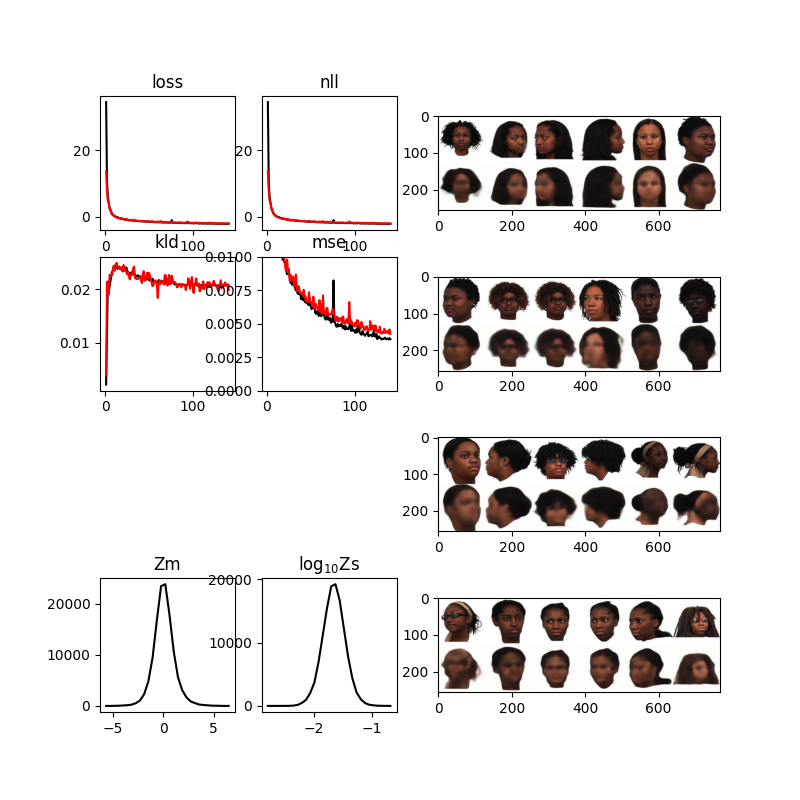

In [ ]:
from IPython.display import Image, display
import glob

# Get latest plot
plot_files = sorted(glob.glob(os.path.join(fdir, "*.png")))
if plot_files:
    latest_plot = plot_files[-1]
    print(f"Latest reconstruction plot: {latest_plot}")
    display(Image(filename=latest_plot))
else:
    print("No plots generated yet")

## 15. Next Steps

### To continue training:
1. Keep this notebook running
2. Increase `CONFIG['epochs']` in cell 7
3. Re-run cells 10-12

### To train GPPVAE next:
1. Use the trained VAE weights from this run
2. Create a similar notebook for `train_gppvae.py`
3. Or download weights and run locally

### Performance comparison:
- **Colab GPU (T4)**: ~5-10 min for 100 epochs
- **M1 Pro CPU**: ~2 hours for 10 epochs
- **Speedup**: 50-100x faster! 🚀